In [39]:
%%capture
# Let's start by installing a few required packages. The installation requirements depend on the execution environments.

# Lunar Lander gym environment.
! pip install gym gym[box2d]
! pip install box2d

# Visualization of the animation.
! pip install ipywidgets

In [40]:
%%capture
# simple neural network implementation of qlearning
#import gym
import pickle
import random

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import gymnasium as gym

from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm
from IPython.display import HTML, display
from PIL import Image
from pathlib import Path
from collections import deque
from statistics import mean

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.keras.utils.disable_interactive_logging()

# Disable progress bar during training
class DisableProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        tqdm._instances.clear()

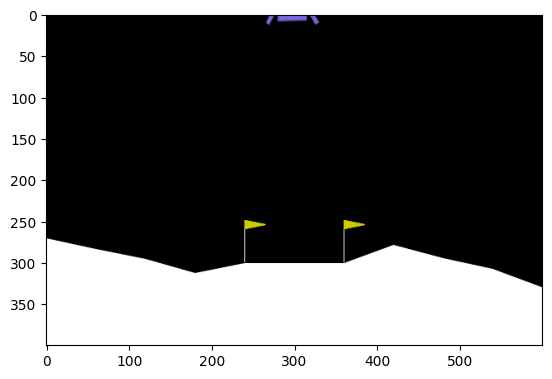

In [41]:
seed = 111

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# For Kaggle
#import os
#os.environ["SDL_VIDEODRIVER"] = "dummy"

# Lunar Lander environment initialization
env = gym.make("LunarLander-v3", render_mode='rgb_array')
obs = env.reset()
image = env.render()
plt.imshow(image)

In [42]:
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

def create_model():
    """Construct the critic network with q-values per action as output"""
    model = keras.Sequential([
        layers.Input(shape=(N_STATES,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu", name='prunable'),
        layers.Dense(N_ACTIONS, activation='linear')
    ])

    model.compile(optimizer=optimizers.Adam(.001), loss='mse')

    return model

model = create_model()
model.summary()

In [ ]:
GAMMA = .99
DECAY_FACTOR = .99995
BATCH_SIZE = 64
MAX_EPISODES = 500      #800
ACCEPTABLE_AVERAGE_SCORE_THRESHOLD = 120    #200
MAX_ACCEPTABLE_AVG_SCORE_COUNTER = 20      #100

def Trainer(m, callbacks=[]):
    memory = []
    last_100_scores = deque(maxlen=100)
    epsilon = 1.0
    acceptable_avg_score_counter = 0

    def choosePlay(state):
        nonlocal epsilon
        random_action = lambda: np.random.randint(N_ACTIONS)

        def predicted_action():
            q_values = m(tf.expand_dims(state, 0))
            action = tf.squeeze(tf.argmax(q_values, axis=-1))
            return action.numpy()

        action =  random_action() if np.random.random() <= epsilon else predicted_action()
        epsilon *= DECAY_FACTOR

        return action

    def obs_to_state(obs):
        if isinstance(obs, tuple):
            obs = obs[0]  # Extract the observation array
        
        obs_array = np.array(obs, dtype=np.float32)
        #print(obs_array)
        
        return obs_array

    def play(state):
        action = choosePlay(state)
        result = env.step(action)
        #print(f"env.step(action) returned: {result}")  # Debugging

        # Adjust unpacking for 5 values
        if len(result) == 5:
            obs, reward, done, _, _ = result
        elif len(result) == 4:
            obs, reward, done, _ = result  # Handle older gym versions
        else:
            raise ValueError(f"Unexpected output from env.step(action): {result}")

        #obs, reward, done, _ = env.step(action)
        new_state = obs_to_state(obs)

        return action, reward, new_state, done

    def train_step(state):
        # Play to gain experience
        action, reward, new_state, done = play(state)
        new_state = np.zeros_like(state) if done else new_state

        # Store experience in the memory bank
        memory.append((state, action, reward, new_state))

        # Train the network with a batch of the gained experience
        batch = np.asarray(random.sample(memory, min(len(memory), BATCH_SIZE)), dtype=object)
        q_s_a = m.predict(np.stack(batch[:, 0], axis = 0))  #Q(s,a)
        q_s_a_next = m.predict(np.stack(batch[:, 3], axis = 0))  #Q(s',a)

        for item_id in range(batch.shape[0]):
            if np.array_equal(batch[item_id, 3], np.zeros(N_STATES)):
                q_s_a[item_id, batch[item_id, 1]] = batch[item_id, 2]
            else:
                q_s_a[item_id, batch[item_id, 1]] = batch[item_id, 2] + GAMMA*np.amax(q_s_a_next[item_id, :])

        m.fit(np.stack(batch[:, 0], axis = 0), q_s_a, batch_size=BATCH_SIZE, verbose=0, callbacks=[DisableProgressBar(), *callbacks])

        return new_state, reward, done

    def record_episode(episode_id, step_id, score, reward, results):
        nonlocal acceptable_avg_score_counter

        # Update the last 100 scores queue with the latest score
        last_100_scores.append(score)

        # Collect episode results
        mean_last_100_scores = mean(last_100_scores)
        results.append((step_id, reward, score, mean_last_100_scores))

        # Increment the counter if the episode scores past the acceptance threshold
        # Reset the counter if the episode falls below the acceptance threshold
        if mean_last_100_scores > ACCEPTABLE_AVERAGE_SCORE_THRESHOLD:
            acceptable_avg_score_counter += 1
        else:
            acceptable_avg_score_counter = 0

        print(
            'Episode:', episode_id,
            'Steps:', step_id,
            'Score:', score,
            '100_rolling_average:', mean_last_100_scores,
            'Acceptable Average Score Count:', acceptable_avg_score_counter,
        )

    def train(episodes=MAX_EPISODES, steps=1000):
        results = []

        for episode_id in range(episodes):
            obs = env.reset()
            state = obs_to_state(obs)
            score = 0

            for step_id in range(steps):
                state, reward, done = train_step(state)
                score += reward

                if done:
                    record_episode(episode_id, step_id, score, reward, results)
                    break

            # Terminate training if the average score meet the acceptance threshold
            # for MAX_ACCEPTABLE_AVG_SCORE_COUNTER episodes in sequence.
            if acceptable_avg_score_counter >= MAX_ACCEPTABLE_AVG_SCORE_COUNTER:
                break

        return results

    return train

trainer = Trainer(model)
results = trainer()

with open('lunar_lander.results.pkl', 'wb') as f:
    pickle.dump(results, f)

model.save_weights('lunar_lander.weights.h5')

Episode: 0 Steps: 84 Score: -194.0082916469912 100_rolling_average: -194.0082916469912 Acceptable Average Score Count: 0
Episode: 1 Steps: 97 Score: -258.6840957157313 100_rolling_average: -226.34619368136126 Acceptable Average Score Count: 0
Episode: 2 Steps: 98 Score: -124.463041268665 100_rolling_average: -192.38514287712917 Acceptable Average Score Count: 0
Episode: 3 Steps: 74 Score: -79.70224740906565 100_rolling_average: -164.2144190101133 Acceptable Average Score Count: 0
Episode: 4 Steps: 76 Score: -169.7844647981667 100_rolling_average: -165.32842816772398 Acceptable Average Score Count: 0
Episode: 5 Steps: 109 Score: -173.44923764916052 100_rolling_average: -166.68189641463007 Acceptable Average Score Count: 0
Episode: 6 Steps: 96 Score: -313.1433142724201 100_rolling_average: -187.60495610860008 Acceptable Average Score Count: 0
Episode: 7 Steps: 109 Score: -336.94891410785874 100_rolling_average: -206.27295085850741 Acceptable Average Score Count: 0
Episode: 8 Steps: 131 S

In [ ]:
from ipywidgets import Label

def load_results(file):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        columns = ['Steps', 'Reward', 'Score', 'R100_Score']
        return pd.DataFrame(results, columns=columns)

def show_results(df):
    df['Done'] = df['Reward'] == 100
    df['Crashed'] = df['Reward'] == -100

    # Plot rolling scores
    plt.plot(df['Score'], label='Scores')
    plt.plot(df['R100_Score'], label='Rolling Scores [100 Episodes]')
    plt.legend()
    plt.title('Scores and Rolling Scores')
    plt.xlabel('Episodes')
    plt.ylabel('Scores')

    display(Label('Training Results'), df)

def summarize_results(file):
    df = load_results(file)
    show_results(df)

    # Display Summary
    successes = len(df[df['Done'] == True])
    crashes = len(df[df['Crashed'] == True])
    timeouts = len(df.loc[(df['Crashed'] == False) & (df['Done'] == False)])
    print('Successes:', successes, 'Crashes:', crashes, 'Timeouts:', timeouts)

    # Top and bottom scores
    sorted_scores = df.sort_values('Score', ascending=False)
    display(Label('Top Scores'), sorted_scores.head())
    display(Label('Bottom Scores'), sorted_scores.tail())

    steps_benchmarks = [0, 200, 300, 500, 700, 1000]
    benchmark_df = pd.DataFrame(columns=['Start', 'End', 'Count', 'Successes', 'Crashes', 'Timeouts'])

    for bm in range(1, len(steps_benchmarks)):
        start, end = steps_benchmarks[bm - 1], steps_benchmarks[bm]
        range_cond = (df['Steps']>=start) & (df['Steps']<end)

        count = len(df.loc[range_cond])
        successes = len(df.loc[range_cond & df['Done'] == True])
        crashes = len(df.loc[range_cond & df['Crashed'] == True])
        timeouts = len(df.loc[range_cond & (df['Crashed'] == False) & (df['Done'] == False)])

        benchmark_df.loc[bm-1] = (start, end, count, successes, crashes, timeouts)

    # Training Benchmarks
    display(Label('Training Benchmarks'), benchmark_df)

    # Episode Steps Histogram
    successes_df = df.loc[df['Done'] == True]['Steps']
    crashes_df = df.loc[df['Crashed'] == True]['Steps']

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
    successes_df.hist(ax=axes[0])
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Number of Episodes')
    axes[0].set_title('Successful Episodes')
    axes[0].set_xticks(range(0, 1000, 100))

    crashes_df.hist(ax=axes[1])
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Number of Episodes')
    axes[1].set_title('Crashed Episodes')
    fig.suptitle('Histogram of the steps in an episode')

# summarize_results('sample_lunar_lander.results.pkl')
summarize_results('lunar_lander.results.pkl')

In [ ]:
def save_visuals(env, frames):
    # Save the current game visuals
    frame = env.render()
    frames.append(frame)

def save_frames_as_gif(container, episode_id, frames):
    gif = Image.fromarray(np.copy(frames[0]))

    gif_name = 'lunar_lander.{}.{}.gif'.format(episode_id, random.randint(0,int(2e9)))

    gif.save(
        gif_name,
        append_images=list(map(lambda im: Image.fromarray(im), frames[1:])),
        save_all=True, duration=5, loop=0
    )

    container[episode_id] = gif_name

def trial_run(m):
    def obs_to_state(obs):
        if isinstance(obs, tuple):
            obs = obs[0]  # Extract the observation array
        
        obs_array = np.array(obs, dtype=np.float32)
        #print(obs_array)
        
        return obs_array

    def predicted_action(state):
        q_values = m(tf.expand_dims(state, 0))
        action = tf.squeeze(tf.argmax(q_values, axis=-1))
        return action.numpy()

    obs = env.reset()
    score = 0
    frames = []

    for step_id in range(1000):
        state = obs_to_state(obs)
        action = predicted_action(state)
        result = env.step(action)
        #obs, reward, done, _ = env.step(action)
        if len(result) == 5:
            obs, reward, done, _, _ = result
        elif len(result) == 4:
            obs, reward, done, _ = result  # Handle older gym versions
        else:
            raise ValueError(f"Unexpected output from env.step(action): {result}")
        score += reward
    



        # Save visuals
        save_visuals(env, frames)

        if done:
            print('Finished with total score:', score, 'in steps: ', step_id)
            break

    print('Total Score:', score, 'Done:', done)
    return frames

# model.load_weights('sample_lunar_lander.weights.h5')
container, frames = {}, trial_run(model)
save_frames_as_gif(container, 0, frames)

In [ ]:
import ipywidgets as ipyw

def create_expanded_button(description, button_style):
    return ipyw.Button(description=description, button_style=button_style, layout=ipyw.Layout(height='auto', width='auto'))

def image_widget(file):
    with open(file, "rb") as file:
        image = file.read()
        # return Image(value=image, width=w, height=h)
        return ipyw.Image(value=image)

def image_label_widget(title, file):
    image = image_widget(file)
    label = ipyw.Label(value=title)
    layout = ipyw.Layout(display='flex', flex_flow='column', align_items='stretch', border='solid')
    box = ipyw.Box(children=[image, label], layout=layout)
    return box

def display_gifs_grid(images, cols=5):
    rows = (len(images)+cols-1) // cols
    grid = ipyw.GridspecLayout(rows, cols)

    for index, image in images.items():
        gcol = index%cols
        grow = index//cols

        grid[grow, gcol] = image_label_widget(str(index), image)

    return grid

display_gifs_grid(container, cols=1)